## **Bank churn prediction** 

Aims: Build a prediction model that will perform the following: Classify if a customer is going to churn or not
Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

In [71]:
# Importing project dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
import itertools
from matplotlib import rc,rcParams
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score

#### **----------------------------------  1. Data collection  -----------------------------------**

In [72]:
# Importing data through API 
!kaggle datasets download -d kmalit/bank-customer-churn-prediction -p ..\Data --unzip 

404 - Not Found


In [73]:
# Loading data into dataframe 
data = pd.read_csv('../Data/Churn_Modelling.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [74]:
# Viewing dataset shape
data.shape

(10000, 14)

In [75]:
# Unique count for each variable
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [76]:
# Check variable data types
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [77]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [78]:
# 2nd check for number of null values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [79]:
data.isna().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [80]:
# Dropping columns that arent needed 
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [81]:
# removing potential capital letters and spaces in column headers
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

In [82]:
# Viewing first 5 rows of dataframe
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### **----------------------------------  3. Exploratory data analysis  -----------------------------------**

In [83]:
amount_retained = data[data['exited'] == 0]['exited'].count() / data.shape[0] * 100
amount_lost = data[data['exited'] == 1]['exited'].count() / data.shape[0] * 100

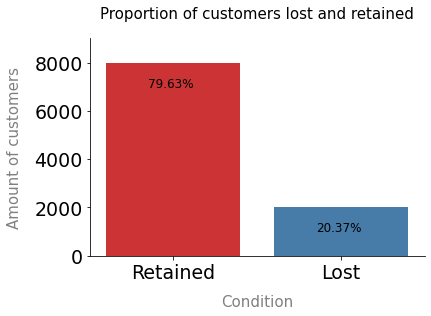

In [84]:
fig, ax = plt.subplots()
sns.countplot(x='exited', palette="Set1", data=data)
plt.xticks([0, 1], ['Retained', 'Lost'])
plt.xlabel('Condition', size=15, labelpad=12, color='grey')
plt.ylabel('Amount of customers', size=15, labelpad=12, color='grey')
plt.title("Proportion of customers lost and retained", size=15, pad=20)
plt.ylim(0, 9000)
plt.text(-0.15, 7000, f"{round(amount_retained, 2)}%", fontsize=12)
plt.text(0.85, 1000, f"{round(amount_lost, 2)}%", fontsize=12)
sns.despine()
plt.show()

<AxesSubplot:>

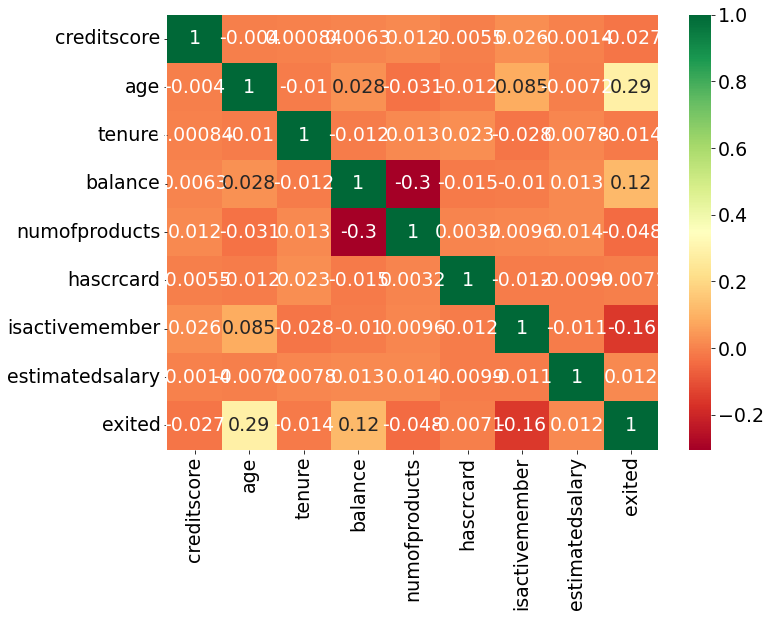

In [85]:
f, ax = plt.subplots(figsize=(11, 8)) 
sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\User

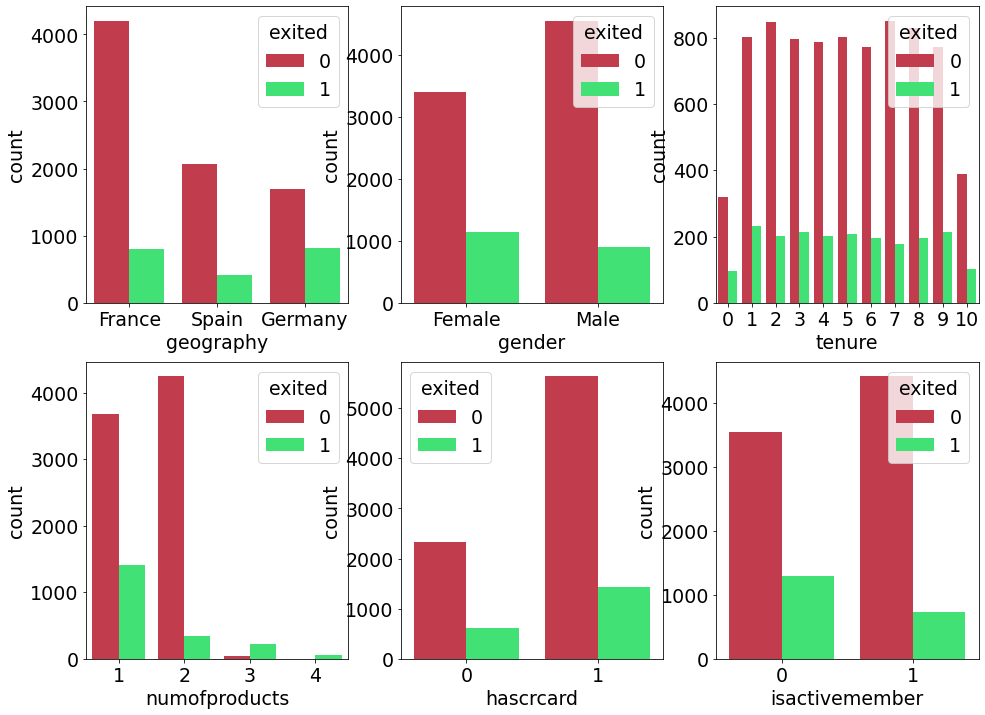

In [86]:
#Putting all the above results in a single visualization

fig_data=['geography', 'gender', 'tenure','numofproducts', 'hascrcard','isactivemember']
q=1
plt.figure(figsize=(16,12))
# Plot a grid with count plots of all categorical variables
for j in fig_data:
    plt.subplot(2,3,q)
    ax=sns.countplot(data[j],hue=data.exited, palette=['#D7263D','#27FB6B'])
    plt.xlabel(j)
    q+=1
plt.show()

In [87]:
female_churn = round(data[(data['exited'] == 1) & (data['gender'] == 'Female')]['exited'].count() / data[data['gender'] == 'Female']['exited'].count()*100, 2)
male_churn = round(data[(data['exited'] == 1) & (data['gender'] == 'Male')]['exited'].count() / data[data['gender'] == 'Male']['exited'].count() * 100, 2)

print(f"The percentage of female customers churning is {female_churn}% while the percetage of male customers churning is {male_churn}%")

The percentage of female customers churning is 25.07% while the percetage of male customers churning is 16.46%


In [88]:
active_churn = round(data[(data['exited'] == 1) & (data['isactivemember'] == 1)]['exited'].count() / data[data['isactivemember'] == 1]['exited'].count()*100, 2)
inactive_churn = round(data[(data['exited'] == 1) & (data['isactivemember'] == 0)]['exited'].count() / data[data['isactivemember'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of active members churning is {active_churn}% while the percetage of inactive members churning is {inactive_churn}%")

The percentage of active members churning is 14.27% while the percetage of inactive members churning is 26.85%


In [89]:
credit_churn = round(data[(data['exited'] == 1) & (data['hascrcard'] == 1)]['exited'].count() / data[data['hascrcard'] == 1]['exited'].count()*100, 2)
no_credit_churn = round(data[(data['exited'] == 1) & (data['hascrcard'] == 0)]['exited'].count() / data[data['hascrcard'] == 0]['exited'].count() * 100, 2)

print(f"The percentage of custumers with credit card churning is {credit_churn}% while the percetage that do not have credit cards and")
print(f"churn is {no_credit_churn}%")

The percentage of custumers with credit card churning is 20.18% while the percetage that do not have credit cards and
churn is 20.81%


In [90]:
# Viewing first 5 rows of dataframe
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<AxesSubplot:xlabel='exited', ylabel='estimatedsalary'>

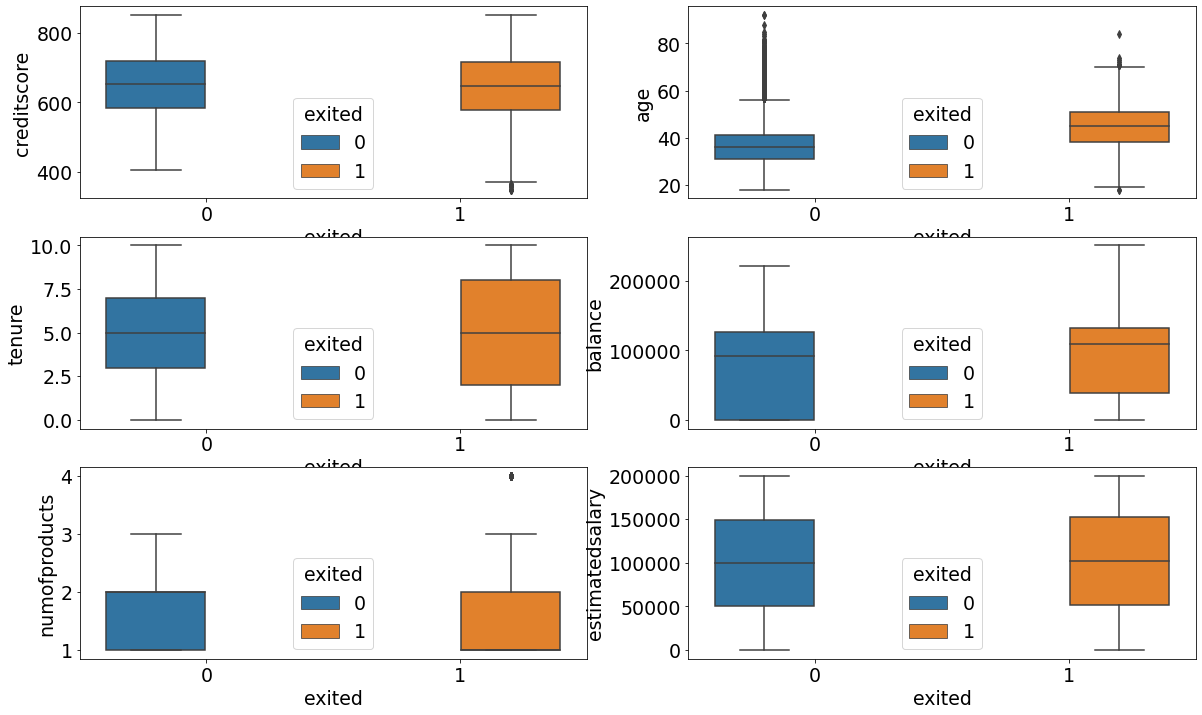

In [91]:
 # Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='creditscore',x = 'exited', hue = 'exited',data = data, ax=axarr[0][0])
sns.boxplot(y='age',x = 'exited', hue = 'exited',data = data , ax=axarr[0][1])
sns.boxplot(y='tenure',x = 'exited', hue = 'exited',data = data, ax=axarr[1][0])
sns.boxplot(y='balance',x = 'exited', hue = 'exited',data = data, ax=axarr[1][1])
sns.boxplot(y='numofproducts',x = 'exited', hue = 'exited',data = data, ax=axarr[2][0])
sns.boxplot(y='estimatedsalary',x = 'exited', hue = 'exited',data = data, ax=axarr[2][1])

#### **----------------------------------  4. Feature engineering  -----------------------------------**

In [92]:
# Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
data['creditscoreageratio'] = data['creditscore'] / data['age']

In [93]:
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,creditscoreageratio
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,19.767442


In [94]:
# One Hot encoding
data = pd.get_dummies(data, columns =["geography", "gender"], drop_first = False)
data.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,creditscoreageratio,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,14.738095,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,14.829268,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,11.952381,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,17.923077,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,19.767442,0,0,1,1,0


In [95]:
y= data['exited']
cat_data = data[["geography_Germany", "geography_France","geography_Spain", "gender_Male","gender_Female" ,"hascrcard","isactivemember"]]
X= data.drop(labels=["exited","geography_Germany", "geography_France","geography_Spain", "gender_Male","gender_Female" ,"hascrcard","isactivemember"],axis=1)

In [96]:
X

,creditscore,age,tenure,balance,numofproducts,estimatedsalary,creditscoreageratio
0,619,42,2,0.00,1,101348.88,14.738095
1,608,41,1,83807.86,1,112542.58,14.829268
2,502,42,8,159660.80,3,113931.57,11.952381
3,699,39,1,0.00,2,93826.63,17.923077
4,850,43,2,125510.82,1,79084.10,19.767442
...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,96270.64,19.769231
9996,516,35,10,57369.61,1,101699.77,14.742857
9997,709,36,7,0.00,1,42085.58,19.694444
9998,772,42,3,75075.31,2,92888.52,18.380952


In [97]:
cols = X.columns
index = X.index

In [98]:
# Robust scaler to sort out outliers 
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)
X = pd.concat([X,cat_data], axis = 1)
X.head()

,creditscore,age,tenure,balance,numofproducts,estimatedsalary,creditscoreageratio,geography_Germany,geography_France,geography_Spain,gender_Male,gender_Female,hascrcard,isactivemember
0,-0.246269,0.416667,-0.75,-0.761480,0.0,0.011739,-0.370690,0,1,0,0,1,1,1
1,-0.328358,0.333333,-1.00,-0.104906,0.0,0.125512,-0.357423,0,0,1,0,1,0,1
2,-1.119403,0.416667,0.75,0.489346,2.0,0.139630,-0.776023,0,1,0,0,1,1,0
3,0.350746,0.166667,-1.00,-0.761480,1.0,-0.064717,0.092739,0,1,0,0,1,0,0
4,1.477612,0.500000,-0.75,0.221806,0.0,-0.214561,0.361102,0,0,1,0,1,1,1


In [99]:
print(X.shape, y.shape)

(10000, 14) (10000,)


In [100]:
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.20, random_state=23, shuffle=True, stratify=y)

#### **----------------------------------  5. Model Fitting  -----------------------------------**

We are ready to build different models looking for the best fit. Predicting customer churn is a binary classification problem: Customers are either lost or retained in a given period of time.

For this aim, I'll test:

* Logistic regression classifier
* Support Vector Machine with Radial basis function kernel
* Random Forest

In [101]:
models = []
models.append(('LR', LogisticRegression(random_state = 10101)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 10101)))
models.append(('RF', RandomForestClassifier(random_state = 10101)))
models.append(('SVM', SVC(gamma='auto', random_state = 10101)))

# evaluate each model in turn
results = []
names = []

In [102]:
for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

LR: (0.818000)
KNN: (0.835500)
CART: (0.803000)
RF: (0.868000)
SVM: (0.862500)


C:\Users\matti\anaconda3\envs\P2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


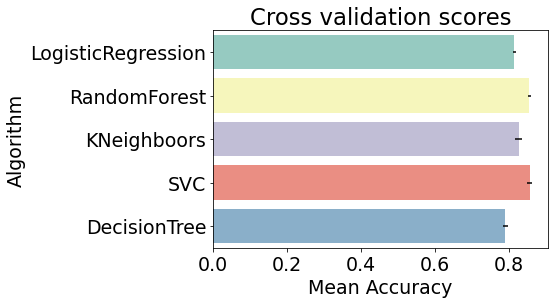

In [103]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)
# Modeling step Test differents algorithms 
random_state = 10101
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(RandomForestClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())


cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogisticRegression","RandomForest","KNeighboors","SVC","DecisionTree"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [104]:
cv_res[['CrossValMeans','Algorithm']]

,CrossValMeans,Algorithm
0,0.815000,LogisticRegression
1,0.854875,RandomForest
2,0.826500,KNeighboors
3,0.855625,SVC
4,0.789875,DecisionTree


In [105]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()

In [106]:
rf = RandomForestClassifier(random_state = random_state)
param_grid = {'n_estimators': [50],
              'criterion': ['entropy', 'gini'],
              'bootstrap': [True],
              'max_depth': [6],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [2, 3, 5],
              'min_samples_split': [2, 3, 5]}
                                  
scoring_metric='recall'
clf_rf = GridSearchCV(rf, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train, y_train)

In [107]:
print(best_clf_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10101),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['entropy', 'gini'],
                         'max_depth': [6], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [2, 3, 5], 'n_estimators': [50]},
             scoring='recall', verbose=False)


In [108]:
y_pred = best_clf_rf.predict(X_test)


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1593
           1       0.88      0.37      0.52       407

    accuracy                           0.86      2000
   macro avg       0.87      0.68      0.72      2000
weighted avg       0.86      0.86      0.84      2000


Confusion Matrix:
[[1573   20]
 [ 257  150]]


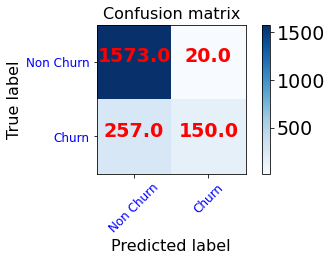

In [109]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(confusion_matrix(y_test,y_pred),classes=['Non Churn','Churn'],title='Confusion matrix')

In [113]:
rf1=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10101, verbose=0,
            warm_start=False)
feature_imp = pd.Series(rf1.fit(X_train, y_train).feature_importances_,
                        index=X.columns).sort_values(ascending=False)

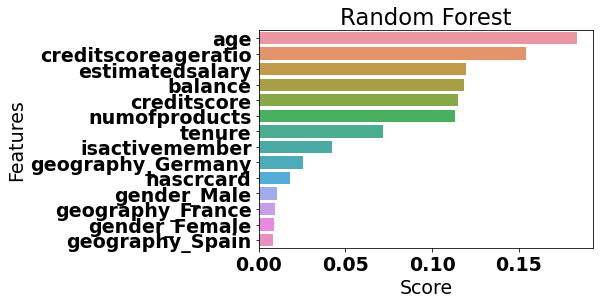

In [114]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title("Random Forest")
plt.show()

In [115]:
# SVC
SVM = SVC()


param_grid = {
                'C': [0.1, 1, 10], 
                'gamma': [0.01, 0.1, 1],
                'kernel': ['rbf']
}

gs_SVM = GridSearchCV(SVM, param_grid, cv=kfold, n_jobs=4)

gs_SVM.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf']})

In [116]:
y_pred = gs_SVM.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.43      0.56       407

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


Confusion Matrix:
[[1545   48]
 [ 232  175]]


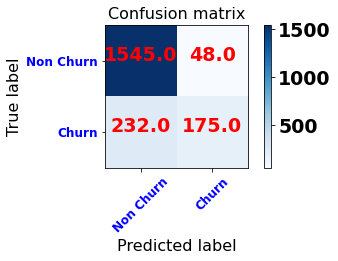

In [117]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred),classes=['Non Churn','Churn'],title='Confusion matrix')